# Comparing eCLIP with DeSeq results using Metadensity
This allows us to generate hypothesis about RBP function - whether it stabilize or destabilize RNA?

In [1]:
# set up files associated with each genome coordinates
import metadensity as md
md.settings.from_config_file('/home/hsher/Metadensity/config/hg38.ini')


# then import the modules
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt


# I have a precompiles list of ENCODE datas as a csv that loads in this dataloader
import sys
sys.path.append('/home/hsher/Metadensity/scripts')
from dataloader import *
%matplotlib inline

plt.style.use('seaborn-white')

Using /home/hsher/gencode_coords/GRCh38.p13.genome.fa
using /home/hsher/gencode_coords/GRCh38.p13.genome.fa
Using:  /home/hsher/gencode_coords/gencode.v33.transcript.gff3


## Get all the DESeq files for each KD experiment
Here we use ENCODE KD-RNA-seq DeSeq outputs

In [2]:
# parse DE filenames
de_path = '/home/hsher/deseq_gccor/normalized/'
all_de_files = os.listdir(de_path)
all_de_files.remove('result_URLs_HepG2.txt')
all_de_files.remove('result_URLs_K562.txt')
all_de_files_rbp = [f.split('-')[0] for f in all_de_files if '-' in f]
all_de_files_cell = [f.split('-')[2].split('_')[0] for f in all_de_files if '-' in f]
de_df = pd.DataFrame([all_de_files, all_de_files_rbp, all_de_files_cell]).T
de_df.columns = ['fname', 'rbp', 'cell line']

In [3]:
de_df.head()

,fname,rbp,cell line
0,PRPF8-BGHLV17-HepG2_DESeq2_output.txt,PRPF8,HepG2
1,RECQL-LV08-K562_DESeq2_output.txt,RECQL,K562
2,TRIM56-BGHLV20-HepG2_DESeq2_output.txt,TRIM56,HepG2
3,ESF1-BGHLV30-HepG2_DESeq2_output.txt,ESF1,HepG2
4,MTPAP-BGKLV34-K562_DESeq2_output.txt,MTPAP,K562


## The main idea is to build Metagene density on upregulated,dowregulated transcripts, and thos in the nochange group



In [4]:
def DEseq_result(fname):
    ''' return transcript ID that is up and down regulated'''
    # read DEseq results
    de = pd.read_csv(de_path+ fname, sep = '\t', header = 0, index_col = 0)
    
    # select those significant
    de = de[de['padj']< 0.05]
    de.reset_index(inplace = True)
    
    # select fold change high
    up = de.loc[de['log2FoldChange']> 1]
    down = de.loc[de['log2FoldChange']< -1]
    
    # remove version
    up = [i.split('.')[0] for i in up['index'].tolist()]
    down = [i.split('.')[0] for i in down['index'].tolist()]
    return up, down
    
def find_direct_bind(id_list, eCLIP, filter_direct = True, enough_transcript = None):
    ''' find DE genes that has at least 1 idr peak'''
    subset = transcript.filter(lambda x: x.attrs['gene_id'].split('.')[0] in id_list and x.attrs['ID'] in enough_transcript).saveas()
    if filter_direct:
        direct_bind_transcript = subset.intersect(eCLIP.idr, s = True, u = True).saveas()
    else:
        return subset
    
    return direct_bind_transcript

def main(cell_line, rbp, filter_direct = True, thres = 200):
    ''' main function: fetch DESeq transcripts, build metagene for each group'''
    
    # start eCLIP object for you, using internal encode data sheet
    try:
        s = encode_data.loc[(encode_data['RBP'] == rbp)&(encode_data['Cell line'] == cell_line)].iloc[0]
        e = eCLIP.from_series(s)
    except:
        s = encode4_data.loc[(encode4_data['RBP'] == rbp)&(encode4_data['Cell line'] == cell_line)].iloc[0]
        e = eCLIP.from_series(s, single_end = True)
        print('using encode4')
        
    # find transcripts with at least `thres` reads
    transcripts_with_reads = e.enough_transcripts(thres = thres)
    print(len(transcripts_with_reads))
    
    # fetch DE genes
    fname = de_df.loc[(de_df['rbp'] == rbp) & (de_df['cell line'] == cell_line), 'fname'].values[0]
    up, down = DEseq_result(fname)
    
    # further filter for those with at least 1 peak. This step can be ignored
    up_transcripts = find_direct_bind(up, e, filter_direct = filter_direct, enough_transcript = transcripts_with_reads)
    down_transcripts = find_direct_bind(down, e, filter_direct = filter_direct, enough_transcript = transcripts_with_reads)
    
    backgrounds = set(transcripts_with_reads) - set([t.attrs['ID'] for t in up_transcripts])- set([t.attrs['ID'] for t in down_transcripts])
    
    print('# up reg: {} # down reg: {} background: {}'.format(len(up_transcripts), len(down_transcripts), len(backgrounds)))
    
    # then we create metadensity for each of them
    meta_up = Metadensity(e, name=rbp+'_upreg', transcripts = up_transcripts, background_method = 'relative information', normalize = False)
    meta_down = Metadensity(e, name=rbp+'_downreg', transcripts = down_transcripts, background_method = 'relative information', normalize = False)
    meta_back = Metadensity(e, name=rbp+'_nochange', transcript_ids= list(backgrounds), background_method = 'relative information', normalize = False)

    # run
    
    for m in [meta_up, meta_down, meta_back]:
        m.get_density_array()
        
    return [meta_up, meta_down, meta_back]

## Example 1: DDX3X

In [5]:
from collections import defaultdict
def get_color_dict(rbp):
    color_dict = defaultdict(lambda: 'seagreen')
    color_dict[rbp+'_upreg'] = 'tomato'
    color_dict[rbp+'_downreg'] = 'royalblue'
    color_dict[rbp+'_nochange'] = 'grey'
    return color_dict

In [6]:
ddx_metas = main('HepG2', 'DDX3X', filter_direct = False)

4578
# up reg: 113 # down reg: 689 background: 3776
Using: /home/hsher/Metadensity/metadensity/data/hg38/gencode
Done building metagene
Using: /home/hsher/Metadensity/metadensity/data/hg38/gencode
Done building metagene
Using: /home/hsher/Metadensity/metadensity/data/hg38/gencode
Done building metagene


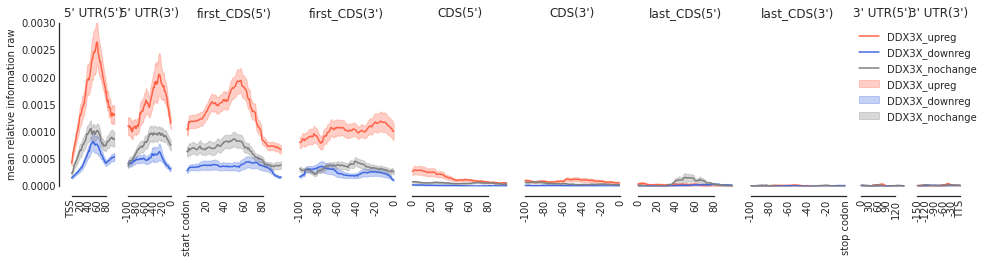

In [7]:

f = plot_mean_density(ddx_metas, plot_std = True, 
                      stat = 'mean', 
                      ymax = 0.003, 
                      alpha = 0.3, 
                      features_to_show = 
                      protein_coding, color_dict = get_color_dict('DDX3X'))
f = beautify(f)

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/metadensity/plotd.py:187: RuntimeWarning: Mean of empty slice
  density_concat = np.nanmean(np.stack([den_arr[feat,align, r] for r in m.eCLIP.rep_keys]), axis = 0)


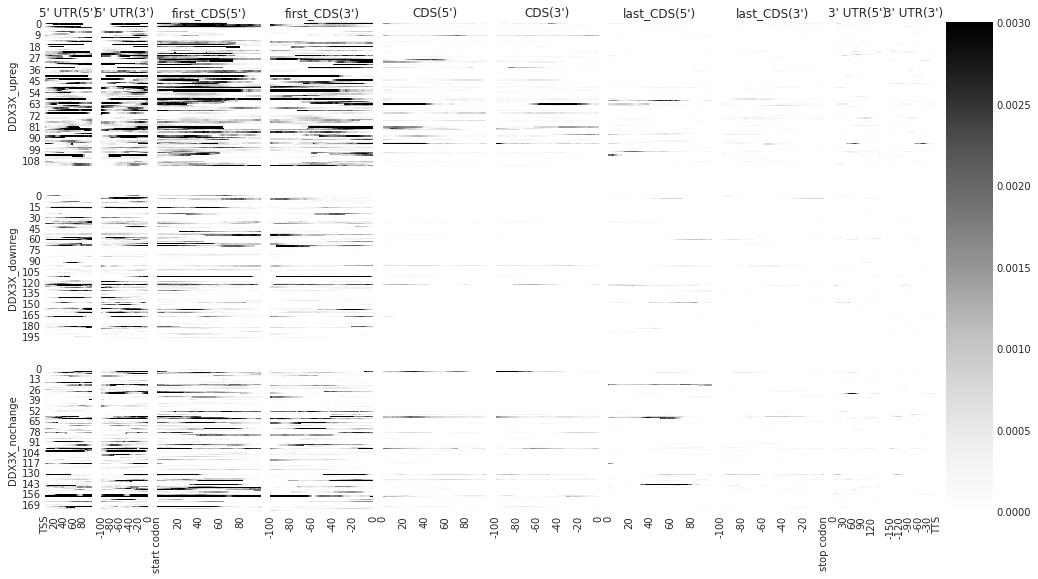

In [8]:
# individually
f = plot_rbp_map(ddx_metas, ymax = 0.003, alpha = 0.3, features_to_show = protein_coding)

## Example 2: UPF1: helicase needed for non-sense mediated decay

In [9]:
upf_metas = main('HepG2', 'UPF1', filter_direct = False) 

3206
# up reg: 225 # down reg: 28 background: 2953
Using: /home/hsher/Metadensity/metadensity/data/hg38/gencode
Done building metagene
Using: /home/hsher/Metadensity/metadensity/data/hg38/gencode
Done building metagene
Using: /home/hsher/Metadensity/metadensity/data/hg38/gencode
Done building metagene


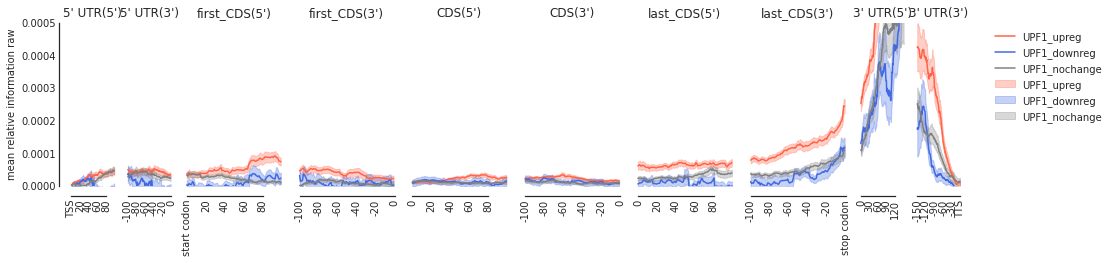

In [10]:
f = plot_mean_density(upf_metas, plot_std = True, stat = 'mean', ymax = 0.0005, alpha = 0.3, features_to_show = protein_coding, color_dict = get_color_dict('UPF1'))
f = beautify(f)